In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [70]:
data = pd.read_json('data/cocktail_dataset.json')
data

,id,name,category,glass,tags,instructions,imageUrl,alcoholic,createdAt,updatedAt,ingredients
0,11000,Mojito,Cocktail,Highball glass,"[IBA, ContemporaryClassic, Alcoholic, USA, Asi...",Muddle mint leaves with sugar and lime juice. ...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:17.000+00:00,2024-08-18T19:06:16.000+00:00,"[{'id': 170, 'name': 'Soda water', 'descriptio..."
1,11001,Old Fashioned,Cocktail,Old-fashioned glass,"[IBA, Classic, Alcoholic, Expensive, Savory]",Place sugar cube in old fashioned glass and sa...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:58.000+00:00,2024-08-18T19:06:17.000+00:00,"[{'id': 513, 'name': 'Water', 'description': '..."
2,11002,Long Island Tea,Ordinary Drink,Highball glass,"[Strong, Asia, StrongFlavor, Brunch, Vegetaria...",Combine all ingredients (except cola) and pour...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:58.000+00:00,2024-08-18T19:06:17.000+00:00,"[{'id': 305, 'name': 'Light Rum', 'description..."
3,11003,Negroni,Ordinary Drink,Old-fashioned glass,"[IBA, Classic]","Stir into glass over ice, garnish and serve.",https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:58.000+00:00,2024-08-18T19:06:17.000+00:00,"[{'id': 482, 'name': 'Sweet Vermouth', 'descri..."
4,11004,Whiskey Sour,Ordinary Drink,Old-fashioned glass,"[IBA, Classic, Alcoholic, ContemporaryClassic]","Shake with ice. Strain into chilled glass, gar...",https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:59.000+00:00,2024-08-18T19:06:18.000+00:00,"[{'id': 409, 'name': 'Powdered Sugar', 'descri..."
...,...,...,...,...,...,...,...,...,...,...,...
129,11985,Quarter Deck Cocktail,Ordinary Drink,Cocktail glass,None,"Stir all ingredients with ice, strain into a c...",https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:11:43.000+00:00,2024-08-18T19:11:43.000+00:00,"[{'id': 305, 'name': 'Light Rum', 'description..."
130,11987,Queen Bee,Ordinary Drink,Cocktail glass,None,"Shake all ingredients with ice, strain into a ...",https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:11:44.000+00:00,2024-08-18T19:11:44.000+00:00,"[{'id': 137, 'name': 'Coffee Brandy', 'descrip..."
131,11989,Queen Charlotte,Ordinary Drink,Collins glass,None,Pour red wine and grenadine into a collins gla...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:11:45.000+00:00,2024-08-18T19:11:45.000+00:00,"[{'id': 250, 'name': 'Grenadine', 'description..."
132,11991,Queen Elizabeth,Ordinary Drink,Cocktail glass,None,"Stir all ingredients with ice, strain into a c...",https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:11:45.000+00:00,2024-08-18T19:11:45.000+00:00,"[{'id': 2, 'name': 'Gin', 'description': 'Gin ..."


# Preproc pipeline

In [71]:
def preproc_pipeline(data: pd.DataFrame):

    def drop_unecessary_columns(data: pd.DataFrame, columns: list) -> pd.DataFrame:
        return data.drop(columns=columns)


    def add_tag_vector_column(df: pd.DataFrame, tag_column: str) -> pd.DataFrame:
        # Extract unique tags from all rows in the tag column
        unique_tags = sorted(set(tag for tags_list in df[tag_column].dropna() for tag in tags_list))
        
        # Function to generate the vector for each row
        def tag_vector(tags):
            return [1 if tag in tags else 0 for tag in unique_tags]
        
        # Apply the function to create a new column with the tag vector
        df['tag_vector'] = df[tag_column].apply(lambda tags: tag_vector(tags) if tags else [0] * len(unique_tags))
        df.drop(columns= tag_column, inplace=True)
        
        return df  
    

    def add_ingredient_vector_column(df: pd.DataFrame, ingredient_column: str) -> pd.DataFrame:
        # Extract unique ingredient names from all rows in the ingredient column
        unique_ingredients = set(
            ingredient['name'] for ingredients_list in df[ingredient_column].dropna() 
            for ingredient in ingredients_list
        )
        unique_ingredients = sorted(unique_ingredients)  # Ensure consistent ordering
        
        # Function to generate the vector for each row
        def ingredient_vector(ingredients):
            ingredient_names = [ingredient['name'] for ingredient in ingredients]
            return [1 if ingredient in ingredient_names else 0 for ingredient in unique_ingredients]
        
        # Apply the function to create a new column with the ingredient vector
        df['ingredient_vector'] = df[ingredient_column].apply(lambda ingredients: ingredient_vector(ingredients) if ingredients else [0] * len(unique_ingredients))
        df.drop(columns= ingredient_column, inplace=True)
        return df


    def add_process_vector_column(df: pd.DataFrame, instruction_column: str) -> pd.DataFrame:
        # domain-based processes in bartending
        common_cocktail_processes = [
            'shake', 'stir', 'muddle', 'strain', 'blend', 'pour', 'build', 'layer',
            'rim', 'garnish', 'fill', 'squeeze', 'top', 'mix', 'flame', 'crush', 
            'dilute', 'press', 'double strain', 'dry shake', 'whip', 'float', 
            'swizzle', 'infuse', 'zest'
        ]

        # Function to extract processes from the instructions
        def extract_processes_from_instructions(instruction, processes_list):
            # Extract processes (simple case-insensitive match for known processes)
            processes_found = [process for process in processes_list if re.search(rf'\b{process.lower()}\b', instruction.lower())]
            return processes_found

        # Apply the function to extract processes
        df['processes_in_instructions'] = df[instruction_column].apply(lambda x: extract_processes_from_instructions(x, common_cocktail_processes))

        # Get unique processes found across all instructions
        unique_processes = sorted(set(process for sublist in df['processes_in_instructions'] for process in sublist))

        # Function to create a binary vector for processes
        def process_vector(processes, all_processes):
            return [1 if process in processes else 0 for process in all_processes]

        # Add the vectorized process column to the DataFrame
        df['process_vector'] = df['processes_in_instructions'].apply(lambda processes: process_vector(processes, unique_processes))
        df.drop(columns= [instruction_column, 'processes_in_instructions'], inplace=True)
        return df

    def normalize_vectors(df: pd.DataFrame, vector_columns: list) -> pd.DataFrame:
       
        def vector_norm(vectors: list) -> float:
            #Calculate the norm (magnitude) of the vector
            return np.linalg.norm(vectors)
        
        # Loop through each vector column and compute the norm
        for col in vector_columns:
            df[f'{col}_norm'] = df[col].apply(vector_norm)
        
        df = df.drop(columns=vector_columns)
        
        return df



    def OHE_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
        # Initialize OneHotEncoder
        ohe = OneHotEncoder(sparse_output=False, drop = 'if_binary', handle_unknown = 'infrequent_if_exist')  
        
        # Apply OHE to the specified columns
        ohe_encoded = ohe.fit_transform(df[columns])
        
        # Convert the result to a DataFrame with appropriate column names
        ohe_encoded_df = pd.DataFrame(ohe_encoded, columns=ohe.get_feature_names_out(columns))
        
        # Drop the original columns that were encoded and concatenate the encoded columns
        df = df.drop(columns, axis=1)
        df = pd.concat([df, ohe_encoded_df], axis=1)
        
        return df


    def LE_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
        # Dictionary to store the LabelEncoders for each column
        label_encoders = {}
        
        for col in columns:
            le = LabelEncoder()
            # Fit the LabelEncoder on the column and transform the values
            df[col] = le.fit_transform(df[col].astype(str))  # Converting to string to handle non-string types
            label_encoders[col] = le  
        
        return df

    


    # Applying functions:
    data = drop_unecessary_columns(data, ['imageUrl', 'createdAt', 'updatedAt', 'id'])
    data = add_tag_vector_column(data, 'tags')
    data = add_ingredient_vector_column(data, 'ingredients')
    data = add_process_vector_column(data, 'instructions')
    data = normalize_vectors(data, ['ingredient_vector', 'tag_vector', 'process_vector'])
    data = OHE_columns(data, ['category', 'alcoholic'])
    data = LE_columns(data, ['glass'])

    return data



In [72]:
preproc_data = preproc_pipeline(data)
preproc_data

,name,glass,ingredient_vector_norm,tag_vector_norm,process_vector_norm,category_Cocktail,category_Ordinary Drink,category_Punch / Party Drink,alcoholic_1
0,Mojito,5,2.236068,3.162278,2.236068,1.0,0.0,0.0,1.0
1,Old Fashioned,6,2.000000,2.236068,1.732051,1.0,0.0,0.0,1.0
2,Long Island Tea,5,2.449490,2.449490,1.000000,0.0,1.0,0.0,1.0
3,Negroni,6,1.732051,1.414214,1.414214,0.0,1.0,0.0,1.0
4,Whiskey Sour,6,2.000000,2.000000,1.732051,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
129,Quarter Deck Cocktail,2,1.732051,0.000000,1.414214,0.0,1.0,0.0,1.0
130,Queen Bee,2,1.732051,0.000000,1.414214,0.0,1.0,0.0,1.0
131,Queen Charlotte,3,1.732051,0.000000,1.732051,0.0,1.0,0.0,1.0
132,Queen Elizabeth,2,1.732051,0.000000,1.414214,0.0,1.0,0.0,1.0


# Modelling

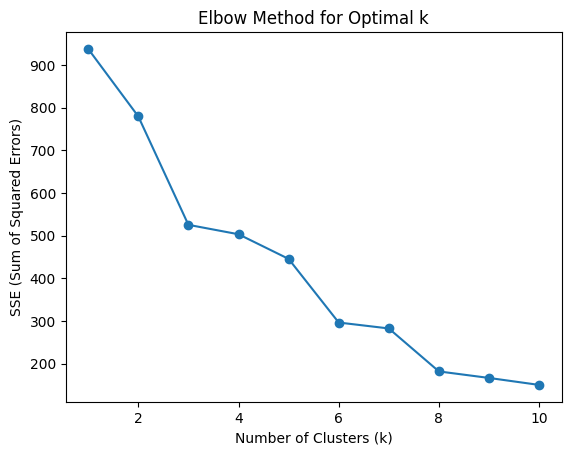

In [73]:
def find_optimal_k(df: pd.DataFrame, max_k: int = 10):
 
    # Drop non-numerical columns and standardize the data
    features_to_cluster = df.drop(columns=['name'])
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features_to_cluster)
    
    # Compute KMeans for different values of k and calculate SSE
    sse = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        sse.append(kmeans.inertia_)
    
    # Plot the SSE for each k value to observe the "elbow"
    plt.plot(range(1, max_k + 1), sse, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('SSE (Sum of Squared Errors)')
    plt.title('Elbow Method for Optimal k')
    plt.show()

find_optimal_k(preproc_data, max_k=10)


In [74]:
def apply_kmeans(df: pd.DataFrame, n_clusters: int) -> pd.DataFrame:
    
    df = df.copy(deep=True)

    features_to_cluster = df.drop(columns=['name'])  # Drop 'name' column
    
    # Standardize the data for clustering
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features_to_cluster)
    
    # Apply KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(scaled_data)
    
    return df

# Apply KMeans with 4 - 6 clusters
clustered_data_k4 = apply_kmeans(preproc_data, n_clusters=4)
clustered_data_k5 = apply_kmeans(preproc_data, n_clusters=5)
clustered_data_k6 = apply_kmeans(preproc_data, n_clusters=6)




In [75]:
def print_unique_clusters_by_name(df: pd.DataFrame):

    # Ensure uniqueness of cocktail names
    unique_names = set()
    
    # Group by cluster and list cocktail names
    clusters = df.groupby('cluster')['name'].apply(list)
    
    # Print each cluster with unique cocktail names
    for cluster, names in clusters.items():
        # Filter out names that have already been printed (to ensure uniqueness across clusters)
        unique_names_in_cluster = [name for name in names if name not in unique_names]
        
        # Add the names to the global unique set to track already printed names
        unique_names.update(unique_names_in_cluster)
        
        # Print the cluster and the unique cocktail names
        print(f"Cluster {cluster + 1}:")
        print(", ".join(unique_names_in_cluster) if unique_names_in_cluster else "No unique cocktails in this cluster.")
        print("\n" + "-"*50 + "\n")

#  Print names for 4 clusters with unique cocktail names
print_unique_clusters_by_name(clustered_data_k4)





Cluster 1:
Long Island Tea, Whiskey Sour, Margarita, Alabama Slammer, Alexander, Brandy Alexander, Allegheny, Amaretto Tea, Apricot Lady, Arthur Tompkins, Banana Daiquiri, Bermuda Highball, Bloody Maria, Bloody Mary, Blue Lagoon, Blue Mountain, Bluebird, Boomerang, Boston Sour, Classic Old-Fashioned, Bourbon Sling, Bourbon Sour, Boxcar, Brandy Cobbler, Brandy Flip, Brandy Sour, California Lemonade, Casino Royale, Chicago Fizz, English Highball, English Rose Cocktail, Frisco Sour, Frozen Daiquiri, Frozen Mint Daiquiri, Gin Cooler, Gin Daisy, Gin Fizz, Gin Sling, Gin Smash, Gin Sour, Gin Squirt, Gin Swizzle, Gin Toddy, Grass Skirt, Harvey Wallbanger, Imperial Fizz, Irish Spring, Japanese Fizz, John Collins, Lady Love Fizz, Lone Tree Cooler, Mai Tai, Mississippi Planters Punch, New York Sour, Orange Oasis, Port Wine Flip

--------------------------------------------------

Cluster 2:
Negroni, Daiquiri, Moscow Mule, After Dinner Cocktail, After Supper Cocktail, Alaska Cocktail, Alfie Cockt

In [76]:
#  Print names for 5 clusters with unique cocktail names
print_unique_clusters_by_name(clustered_data_k5)

Cluster 1:
Whiskey Sour, Margarita, Alexander, Brandy Alexander, Allegheny, Amaretto Tea, Apricot Lady, Arthur Tompkins, Banana Daiquiri, Bermuda Highball, Bloody Maria, Bloody Mary, Blue Lagoon, Blue Mountain, Bluebird, Boomerang, Boston Sour, Classic Old-Fashioned, Bourbon Sling, Bourbon Sour, Boxcar, Brandy Cobbler, Brandy Flip, Brandy Sour, California Lemonade, Casino Royale, Chicago Fizz, English Highball, English Rose Cocktail, Frisco Sour, Frozen Daiquiri, Frozen Mint Daiquiri, Gin Cooler, Gin Daisy, Gin Fizz, Gin Sling, Gin Smash, Gin Sour, Gin Squirt, Gin Swizzle, Gin Toddy, Grass Skirt, Harvey Wallbanger, Imperial Fizz, Irish Spring, Japanese Fizz, John Collins, Lady Love Fizz, Lone Tree Cooler, Mai Tai, Mississippi Planters Punch, New York Sour, Orange Oasis, Port Wine Flip

--------------------------------------------------

Cluster 2:
Daiquiri, After Dinner Cocktail, After Supper Cocktail, Alaska Cocktail, Alfie Cocktail, Algonquin, Allies Cocktail, Almeria, Almond Joy, Am

In [77]:
#  Print names for 6 clusters with unique cocktail names
print_unique_clusters_by_name(clustered_data_k6)

Cluster 1:
Margarita, Brandy Alexander, Allegheny, Amaretto Tea, Apricot Lady, Arthur Tompkins, Banana Daiquiri, Bermuda Highball, Bloody Maria, Bloody Mary, Blue Lagoon, Blue Mountain, Bluebird, Boomerang, Boston Sour, Classic Old-Fashioned, Bourbon Sling, Bourbon Sour, Boxcar, Brandy Cobbler, Brandy Flip, Brandy Sour, California Lemonade, Casino Royale, Chicago Fizz, English Highball, English Rose Cocktail, Frozen Daiquiri, Frozen Mint Daiquiri, Gin Cooler, Gin Daisy, Gin Fizz, Gin Sling, Gin Smash, Gin Sour, Gin Squirt, Gin Swizzle, Gin Toddy, Grass Skirt, Imperial Fizz, Irish Spring, Japanese Fizz, John Collins, Lady Love Fizz, Lone Tree Cooler, Mai Tai, Mississippi Planters Punch, New York Sour, Orange Oasis, Port Wine Flip

--------------------------------------------------

Cluster 2:
Daiquiri, After Dinner Cocktail, After Supper Cocktail, Alaska Cocktail, Alexander, Alfie Cocktail, Algonquin, Allies Cocktail, Almeria, Almond Joy, Amaretto And Cream, Amaretto Rose, Amaretto Stin

In [78]:
def evaluate_kmeans(df: pd.DataFrame, min_k: int = 4, max_k: int = 7):

    features_to_cluster = df.drop(columns=['name'])  
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features_to_cluster)
    
    sse = []
    silhouette_scores = []
    ch_scores = []
    db_scores = []
    
    for k in range(min_k, max_k + 1):  
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        
        # Calculate SSE (Sum of Squared Errors)
        sse.append(kmeans.inertia_)
        
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        
        # Calculate Calinski-Harabasz Index
        ch_score = calinski_harabasz_score(scaled_data, kmeans.labels_)
        ch_scores.append(ch_score)
        
        # Calculate Davies-Bouldin Index
        db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
        db_scores.append(db_score)
    
    return sse, silhouette_scores, ch_scores, db_scores

# Evaluate KMeans from 4 to 7 clusters
sse, silhouette_scores, ch_scores, db_scores = evaluate_kmeans(preproc_data, min_k=4, max_k=7)

for i in range(4, 8):  # From 4 to 7 clusters
    print(f"Results for {i} clusters:")
    print(f"  SSE: {sse[i-4]}")
    print(f"  Silhouette Score: {silhouette_scores[i-4]}")
    print(f"  Calinski-Harabasz Index: {ch_scores[i-4]}")
    print(f"  Davies-Bouldin Index: {db_scores[i-4]}")
    print("\n")


Results for 4 clusters:
  SSE: 503.50427202606875
  Silhouette Score: 0.3119450006670379
  Calinski-Harabasz Index: 37.39421740443319
  Davies-Bouldin Index: 1.318814823031391


Results for 5 clusters:
  SSE: 445.7515458246363
  Silhouette Score: 0.3284037434951385
  Calinski-Harabasz Index: 35.61403834906921
  Davies-Bouldin Index: 1.400001659269424


Results for 6 clusters:
  SSE: 296.55820003222357
  Silhouette Score: 0.3310323037104302
  Calinski-Harabasz Index: 55.37162714566924
  Davies-Bouldin Index: 1.097212151917448


Results for 7 clusters:
  SSE: 282.6738421365834
  Silhouette Score: 0.2497956117856257
  Calinski-Harabasz Index: 49.07093715003188
  Davies-Bouldin Index: 1.0707478437651443


Results for 4 clusters:
  SSE: 503.50427202606875
  Silhouette Score: 0.3119450006670379
  Calinski-Harabasz Index: 37.39421740443319
  Davies-Bouldin Index: 1.318814823031391


Results for 5 clusters:
  SSE: 445.7515458246363
  Silhouette Score: 0.3284037434951385
  Calinski-Harabasz Ind

In [79]:
best_n_clusters = 6